## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import librosa

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [4]:
import tensorflow as tf
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Input, add, Dense, BatchNormalization, GRU
from tensorflow.keras.layers import LeakyReLU

## Load Dataset

In [5]:
# Location of Data Folder:
data_folder = '../data/Respiratory_Sound_Data'

In [6]:
# Lung Audio Data Folder:
audio_data_folder = f'{data_folder}/audio_and_txt_files/'

In [7]:
# Test Audio Files:
audio1 = f'{audio_data_folder}104_1b1_Lr_sc_Litt3200.wav'
audio2 = f'{audio_data_folder}224_1b1_Tc_sc_Meditron.wav'
audio3 = f'{audio_data_folder}108_1b1_Al_sc_Meditron.wav'
audio4 = f'{audio_data_folder}182_1b1_Tc_sc_Meditron.wav'
audio5 = f'{audio_data_folder}223_1b1_Al_sc_Meditron.wav'
audio6 = f'{audio_data_folder}226_1b1_Pl_sc_LittC2SE.wav'


In [8]:
diagnosis_df = pd.read_csv('patient_diagnosis_relabelled.csv')

## EDA

In [9]:
diagnosis_df

,pid,diagnosis
0,101,Acute
1,102,Healthy
2,103,Chronic
3,104,Chronic
4,105,Acute
...,...,...
121,222,Chronic
122,223,Chronic
123,224,Healthy
124,225,Healthy


In [10]:
diagnosis_df.head(20)

,pid,diagnosis
0,101,Acute
1,102,Healthy
2,103,Chronic
3,104,Chronic
4,105,Acute
5,106,Chronic
6,107,Chronic
7,108,Acute
8,109,Chronic
9,110,Chronic


In [11]:
diagnosis_df['diagnosis'].unique()

array(['Acute', 'Healthy', 'Chronic'], dtype=object)

In [12]:
diagnosis_df['diagnosis'].nunique()

3

([0, 1, 2],
 [Text(0, 0, 'Acute'), Text(1, 0, 'Healthy'), Text(2, 0, 'Chronic')])

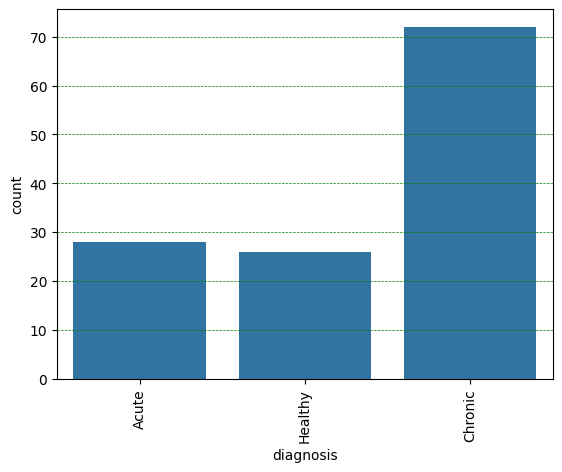

In [13]:
sns.countplot(data=diagnosis_df, x='diagnosis')
plt.grid(axis = 'y',color = 'green', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=90)

In [14]:
diagnosis_df['diagnosis'].value_counts()

diagnosis
Chronic    72
Acute      28
Healthy    26
Name: count, dtype: int64

## Utility Functions

In [15]:
def add_noise(data: np.ndarray, x: float) -> np.ndarray:
    """
    Add random Gaussian noise to an audio signal for data augmentation.
    
    This function generates random noise from a normal distribution and adds it
    to the input audio signal, scaled by a noise factor. This is commonly used
    in audio data augmentation to improve model robustness by simulating 
    real-world noise conditions.
    
    Parameters
    ----------
    data : np.ndarray, shape=(n,)
        Input audio time series as a 1D numpy array containing audio samples.
        Typically obtained from librosa.load().
    x : float
        Noise scaling factor that controls the intensity of added noise.
        Higher values produce more noise. Typical values range from 0.0001 to 0.01.
    
    Returns
    -------
    data_noise : np.ndarray, shape=(n,)
        Audio time series with added Gaussian noise, same shape as input.
        The output maintains the same data type as the input array.
    
    Notes
    -----
    - Uses np.random.randn() to generate standard normal distributed noise
    - The noise is scaled by factor x before being added to the original signal
    - No bounds checking is performed on the output signal amplitude
    - Random seed should be set externally for reproducible results
    
    Examples
    --------
    >>> y, sr = librosa.load("audio.wav")
    >>> y_noisy = add_noise(y, 0.001)
    >>> # Adds subtle noise to the audio signal
    
    >>> y_very_noisy = add_noise(y, 0.01)
    >>> # Adds more prominent noise to the audio signal
    """
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise


def shift(data: np.ndarray, x: int) -> np.ndarray:
    """
    Apply time-domain shifting to an audio signal by rolling samples.
    
    This function shifts audio samples in the time domain by rolling the array
    elements. Positive values shift samples to the right (delayed), while 
    negative values shift samples to the left (advanced). This augmentation
    technique helps models become invariant to temporal shifts in audio data.
    
    Parameters
    ----------
    data : np.ndarray, shape=(n,)
        Input audio time series as a 1D numpy array containing audio samples.
        Typically obtained from librosa.load().
    x : int
        Number of samples to shift. Positive values shift right (delay),
        negative values shift left (advance). Values larger than array length
        will wrap around due to numpy.roll behavior.
    
    Returns
    -------
    shifted_data : np.ndarray, shape=(n,)
        Time-shifted audio signal with the same shape and data type as input.
        Samples that roll off one end appear at the other end (circular shift).
    
    Notes
    -----
    - Uses numpy.roll() which performs circular shifting
    - No audio samples are lost; they wrap around to the opposite end
    - For non-circular shifting, consider padding with zeros instead
    - Shift amount is in samples, not time units
    
    Examples
    --------
    >>> y, sr = librosa.load("audio.wav")
    >>> y_delayed = shift(y, 1000)
    >>> # Delays audio by 1000 samples (~45ms at 22050 Hz)
    
    >>> y_advanced = shift(y, -500)
    >>> # Advances audio by 500 samples (~23ms at 22050 Hz)
    """
    return np.roll(data, x)


def stretch(data: np.ndarray, rate: float) -> np.ndarray:
    """
    Apply time-stretching to an audio signal while preserving pitch.
    
    This function changes the duration of an audio signal without affecting
    its pitch using librosa's phase vocoder-based time stretching. Values
    greater than 1.0 make the audio faster (shorter), while values less than
    1.0 make it slower (longer). This augmentation helps models handle
    variations in speech rate and timing.
    
    Parameters
    ----------
    data : np.ndarray, shape=(n,)
        Input audio time series as a 1D numpy array containing audio samples.
        Typically obtained from librosa.load().
    rate : float
        Time-stretching factor. Must be positive.
        - rate > 1.0: Faster playback (shorter duration)
        - rate < 1.0: Slower playback (longer duration)  
        - rate = 1.0: No change
        Common values range from 0.8 to 1.2.
    
    Returns
    -------
    stretched_data : np.ndarray, shape=(m,)
        Time-stretched audio signal. Output length m = n / rate (approximately).
        Maintains the same data type as input but length will change.
    
    Raises
    ------
    librosa.util.exceptions.ParameterError
        If rate is not positive or if input data is invalid.
    
    Notes
    -----
    - Uses librosa.effects.time_stretch() with phase vocoder algorithm
    - Pitch is preserved during time stretching
    - Output array length will be different from input (length = n / rate)
    - Quality depends on the complexity of the audio signal
    
    Examples
    --------
    >>> y, sr = librosa.load("audio.wav")
    >>> y_fast = stretch(y, 1.2)
    >>> # Makes audio 20% faster (shorter duration)
    
    >>> y_slow = stretch(y, 0.8)  
    >>> # Makes audio 25% slower (longer duration)
    """
    data = librosa.effects.time_stretch(y=data, rate=rate)
    return data


def pitch_shift(data: np.ndarray, rate: float) -> np.ndarray:
    """
    Apply pitch shifting to an audio signal while preserving duration.
    
    This function shifts the pitch of an audio signal by a specified number
    of semitones without changing its duration. Positive values increase pitch
    (higher frequency), while negative values decrease pitch (lower frequency).
    This augmentation helps models become robust to pitch variations in audio.
    
    Parameters
    ----------
    data : np.ndarray, shape=(n,)
        Input audio time series as a 1D numpy array containing audio samples.
        Typically obtained from librosa.load().
    rate : float
        Number of semitones to shift the pitch. Can be positive or negative.
        - Positive values: Higher pitch (e.g., +12 = one octave up)
        - Negative values: Lower pitch (e.g., -12 = one octave down)
        - rate = 0: No change
        Common values range from -5 to +5 semitones.
    
    Returns
    -------
    pitch_shifted_data : np.ndarray, shape=(n,)
        Pitch-shifted audio signal with the same shape and data type as input.
        Duration remains unchanged, only pitch is modified.
    
    Raises
    ------
    librosa.util.exceptions.ParameterError
        If sampling rate is invalid or input data is malformed.
    
    Notes
    -----
    - Uses librosa.effects.pitch_shift() with sampling rate of 22050 Hz
    - WARNING: Hardcoded sampling rate (220250) appears to be a typo and 
      should likely be 22050 Hz (standard rate)
    - Duration is preserved during pitch shifting
    - Uses phase vocoder with time-domain pitch shifting
    - Quality may degrade with extreme pitch shifts (>±12 semitones)
    
    Examples
    --------
    >>> y, sr = librosa.load("audio.wav")
    >>> y_higher = pitch_shift(y, 3)
    >>> # Shifts pitch up by 3 semitones (minor third)
    
    >>> y_lower = pitch_shift(y, -2)
    >>> # Shifts pitch down by 2 semitones (whole tone)
    
    See Also
    --------
    librosa.effects.pitch_shift : Underlying librosa function
    stretch : For time-stretching without pitch change
    """
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [16]:
def show_audio(audio_path: str) -> None:
    """
    Display waveform visualizations of an audio file with various data augmentation techniques.
    
    This function loads an audio file and applies multiple audio augmentation techniques
    (noise addition, time shifting, time stretching, and pitch shifting) to demonstrate
    their effects on the original waveform. All variations are displayed in a 3x2 subplot
    grid for visual comparison.
    
    The function applies the following augmentations with fixed parameters:
    - Noise addition (factor: 0.0008)
    - Time shifting (shift: 3200 samples)
    - Time stretching (rates: 1.2x and 0.8x)
    - Pitch shifting (semitones: +3)
    
    Parameters
    ----------
    audio_path : str
        Path to the audio file to be loaded and visualized. Should be a valid audio
        file format supported by librosa (e.g., .wav, .mp3, .flac).
    
    Returns
    -------
    None
        This function displays the plots directly and does not return any values.
    """
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.waveshow(y_noise, sr=sr)
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.waveshow(y_shift, sr=sr)
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.waveshow(y_stretch_1, sr=sr)
    plt.title('stretch 1')
    
    plt.subplot(3,2,5)
    librosa.display.waveshow(y_stretch_2, sr=sr)
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.waveshow(y_pitch_shift, sr=sr)
    plt.title('pitch shift')

    plt.tight_layout()

In [17]:
def show_audio_features(audio_path: str) -> None:
    """
    Display MFCC feature visualizations of an audio file with various data augmentation techniques.
    
    This function loads an audio file, applies multiple audio augmentation techniques,
    extracts Mel-frequency Cepstral Coefficients (MFCC) features from each variation,
    and displays them as spectrograms in a 3x2 subplot grid. This visualization helps
    understand how different augmentations affect the extracted audio features used
    in machine learning models.
    
    The function applies the following augmentations with fixed parameters:
    - Noise addition (factor: 0.0008)
    - Time shifting (shift: 3200 samples)  
    - Time stretching (rates: 1.2x and 0.8x)
    - Pitch shifting (semitones: +3)
    
    For each variation, 50 MFCC coefficients are extracted and displayed as
    mel-scale spectrograms with power expressed in decibels.
    
    Parameters
    ----------
    audio_path : str
        Path to the audio file to be loaded and analyzed. Should be a valid audio
        file format supported by librosa (e.g., .wav, .mp3, .flac).
    
    Returns
    -------
    None
        This function displays the MFCC spectrograms directly and does not return 
        any values.
    
    Notes
    -----
    - Requires librosa, matplotlib, numpy, and the custom augmentation functions 
      (add_noise, shift, stretch, pitch_shift) to be available in scope
    - Creates a matplotlib figure with 6 subplots arranged in a 3x2 grid
    - Each subplot shows MFCC features as a mel-scale spectrogram in dB
    - MFCC extraction parameters:
      * n_mfcc=50: Number of MFCC coefficients to extract
      * Uses default hop_length (512 samples) and n_fft (2048 samples)
    - Spectrogram display parameters:
      * y_axis='mel': Mel-frequency scale on y-axis
      * x_axis='time': Time scale on x-axis  
      * fmax=8000: Maximum frequency displayed (8 kHz)
      * Colorbar shows power in dB scale (+dB format)
    - All spectrograms use the same color scale for comparison
    
    Technical Details
    -----------------
    MFCC Shape: Each MFCC array has shape (n_mfcc, n_frames) where:
    - n_mfcc = 50 (number of coefficients)
    - n_frames depends on audio duration and hop_length
    
    Power Conversion: Uses librosa.power_to_db() with reference to maximum
    power for consistent dB scaling across all visualizations.
    """
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')
    
    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')
    
    

    plt.tight_layout()

In [ ]:
# # This is the Old Function That I used to generate Augumented Data, Now it is replaced with another function named `mfcc_feature_extraction`.
# def mfccs_feature_exteraction(dir_):
#     '''
#         Extract MFCC feature from the Sound data from the audio data. 
#         Augmentation of sound data by adding Noise, streaching and shifting.
#         50 features are extracted from each audio data and used to train the model. 
        
#         Args: dir_: Input directory to the Sound input file.
        
#         Returns:
#             X_data: Array of features extracted from the sound file.
#             y_data: Array of target Labels.
#     '''
#     X_=[]
#     y_=[]
    
#     Chronic=[]
#     chronic_count=0
    
#     data = diagnosis_df
#     features = 52
#     for soundDir in (os.listdir(dir_)):
#         # if soundDir[-3:]=='wav'and soundDir[:3]!='103':
#         if soundDir[-3:]=='wav':
#             p = list(data[data['pid']==int(soundDir[:3])]['diagnosis'])[0]
#             #---------------
#             if (p=='Chronic'):
#                 if (soundDir[:7] in Chronic) and chronic_count<2:
#                     data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
#                     mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
#                     Chronic.append(soundDir[:7])
#                     chronic_count+=1
#                     X_.append(mfccs)
#                     y_.append(p)
                    
#                 if (soundDir[:7] not in Chronic):
#                     data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
#                     mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
#                     Chronic.append(soundDir[:7])
#                     chronic_count=0
#                     X_.append(mfccs)
#                     y_.append(p)
                
#             elif (p=='Acute') or (p=='Healthy'):
#                 data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
#                 mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
#                 X_.append(mfccs)
#                 y_.append(p)
            
#                 data_noise = add_noise(data_x,0.001)
#                 mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
#                 X_.append(mfccs_noise)
#                 y_.append(p)

#                 data_shift = shift(data_x,1600)
#                 mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
#                 X_.append(mfccs_shift)
#                 y_.append(p)
                    
#                 data_stretch = stretch(data_x,1.2)
#                 mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
#                 X_.append(mfccs_stretch)
#                 y_.append(p)
                    
#                 data_stretch_2 = stretch(data_x,0.8)
#                 mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
#                 X_.append(mfccs_stretch_2)
#                 y_.append(p)
                    
#                 data_pitch_shift = pitch_shift(data_x,3)
#                 mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
#                 X_.append(mfccs_stretch)
#                 y_.append(p)
#             # ---------------------       
                    
#     # print(p)        
#     # print(i)            
#     X_data = np.array(X_)
#     y_data = np.array(y_)
#     return X_data, y_data

In [19]:
# This is the New Function That must be used from now on and not this `mffcs_feature_exteraction`
from typing import Tuple, Optional, Dict, Any

def mfcc_feature_extraction(
    dir_: str, 
    diagnosis_df: pd.DataFrame,
    n_mfcc: int = 52,
    max_chronic_per_patient: int = 2,
    augmentation_params: Optional[Dict[str, Any]] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract MFCC features from audio files with class-balanced data augmentation.
    
    This function processes audio files from a directory, extracts MFCC (Mel-frequency
    Cepstral Coefficients) features, and applies data augmentation selectively based
    on diagnosis class to create a balanced dataset. Chronic cases are limited to
    prevent class imbalance, while Acute and Healthy cases are augmented with multiple
    techniques to increase dataset size.
    
    The function implements different processing strategies per diagnosis:
    - **Chronic**: Limited sampling (max per patient) to prevent overrepresentation
    - **Acute/Healthy**: Full augmentation with 6 variations per original sample
    
    Data augmentation techniques applied to Acute/Healthy cases:
    - Original audio
    - Noise addition
    - Time shifting
    - Time stretching (2 rates)
    - Pitch shifting
    
    Parameters
    ----------
    dir_ : str
        Path to directory containing audio files (.wav format). Directory should
        contain audio files with naming convention where first 3 characters 
        represent patient ID (e.g., "001_recording.wav").
    diagnosis_df : pd.DataFrame
        DataFrame containing patient diagnosis information with columns:
        - 'pid': Patient ID (int) matching first 3 characters of audio filenames
        - 'diagnosis': Diagnosis label ('Chronic', 'Acute', or 'Healthy')
    n_mfcc : int, default=52
        Number of MFCC coefficients to extract from each audio file.
    max_chronic_per_patient : int, default=2
        Maximum number of chronic recordings to process per patient to prevent
        class imbalance.
    augmentation_params : dict, optional
        Dictionary containing augmentation parameters. If None, uses defaults:
        {
            'noise_factor': 0.001,
            'shift_samples': 1600, 
            'stretch_rate_1': 1.2,
            'stretch_rate_2': 0.8,
            'pitch_shift_steps': 3
        }
    
    Returns
    -------
    X_data : np.ndarray, shape=(n_samples, n_mfcc)
        Feature matrix where each row represents one audio sample's MFCC features.
        Features are averaged across time frames.
        Data type is float64.
    y_data : np.ndarray, shape=(n_samples,)
        Target labels corresponding to each sample in X_data.
        Contains strings: 'Chronic', 'Acute', or 'Healthy'.
    
    Notes
    -----
    **Class Balancing Strategy:**
    - Chronic cases: Limited to max recordings per patient to prevent overrepresentation
    - Acute/Healthy cases: Each original file generates 6 samples (1 original + 5 augmented)
    
    **Feature Extraction:**
    - Uses configurable number of MFCC coefficients (default: 52)
    - Features are averaged across time frames using np.mean(..., axis=0)
    - Librosa loads audio with 'kaiser_fast' resampling for speed
    
    **File Processing:**
    - Only processes files ending with '.wav'
    - Patient ID extracted from first 3 characters of filename
    - Chronic patient tracking uses first 7 characters of filename
    
    Examples
    --------
    >>> import pandas as pd
    >>> diagnosis_df = pd.read_csv('patient_diagnosis.csv')
    >>> X_features, y_labels = mfcc_feature_extraction(
    ...     'data/audio_files/', 
    ...     diagnosis_df
    ... )
    >>> print(f"Dataset shape: {X_features.shape}")
    >>> print(f"Label distribution: {np.unique(y_labels, return_counts=True)}")
    
    >>> # With custom parameters
    >>> custom_params = {
    ...     'noise_factor': 0.002,
    ...     'shift_samples': 2000,
    ...     'stretch_rate_1': 1.3,
    ...     'stretch_rate_2': 0.7,
    ...     'pitch_shift_steps': 4
    ... }
    >>> X_custom, y_custom = mfcc_feature_extraction(
    ...     'data/audio_files/', 
    ...     diagnosis_df,
    ...     n_mfcc=40,
    ...     max_chronic_per_patient=3,
    ...     augmentation_params=custom_params
    ... )
    
    See Also
    --------
    librosa.feature.mfcc : MFCC feature extraction
    add_noise : Noise augmentation function
    shift : Time shifting function
    stretch : Time stretching function
    pitch_shift : Pitch shifting function
    """
    
    # Validate inputs
    if not os.path.exists(dir_):
        raise FileNotFoundError(f"Directory {dir_} does not exist")
    
    if not {'pid', 'diagnosis'}.issubset(diagnosis_df.columns):
        raise ValueError("diagnosis_df must contain 'pid' and 'diagnosis' columns")
    
    # Set default augmentation parameters
    if augmentation_params is None:
        augmentation_params = {
            'noise_factor': 0.001,
            'shift_samples': 1600,
            'stretch_rate_1': 1.2,
            'stretch_rate_2': 0.8,
            'pitch_shift_steps': 3
        }
    
    # Initialize containers
    X_features = []
    y_labels = []
    
    # Track chronic patients to limit samples per patient
    # chronic_patients = []
    chronic_patient_counts = {}
    
    # Get list of wav files
    wav_files = [f for f in os.listdir(dir_) if f.endswith('.wav')]
    
    if not wav_files:
        raise ValueError(f"No .wav files found in directory {dir_}")
    
    print(f"Processing {len(wav_files)} audio files...")
    
    for i, sound_file in enumerate(wav_files):
        try:
            # Extract patient ID from filename (first 3 characters)
            patient_id = int(sound_file[:3])
            
            # Get diagnosis for this patient
            patient_data = diagnosis_df[diagnosis_df['pid'] == patient_id]
            if patient_data.empty:
                print(f"Warning: Patient ID {patient_id} not found in diagnosis_df, skipping {sound_file}")
                continue
                
            diagnosis = patient_data['diagnosis'].iloc[0]
            
            # Full file path
            file_path = os.path.join(dir_, sound_file)
            
            # Load audio
            audio_data, sampling_rate = librosa.load(file_path, res_type='kaiser_fast')
            
            if diagnosis == 'Chronic':
                # Handle chronic cases with limited sampling
                patient_key = sound_file[:7]  # First 7 characters for patient tracking
                
                # Initialize count for new patients
                if patient_key not in chronic_patient_counts:
                    chronic_patient_counts[patient_key] = 0
                
                # Only process if under the limit
                if chronic_patient_counts[patient_key] < max_chronic_per_patient:
                    mfcc_features = _extract_mfcc_features(audio_data, sampling_rate, n_mfcc)
                    X_features.append(mfcc_features)
                    y_labels.append(diagnosis)
                    chronic_patient_counts[patient_key] += 1
                    
            elif diagnosis in ['Acute', 'Healthy']:
                # Apply full augmentation for Acute and Healthy cases
                
                # 1. Original audio
                mfcc_original = _extract_mfcc_features(audio_data, sampling_rate, n_mfcc)
                X_features.append(mfcc_original)
                y_labels.append(diagnosis)
                
                # 2. Noise addition
                audio_noise = add_noise(audio_data, augmentation_params['noise_factor'])
                mfcc_noise = _extract_mfcc_features(audio_noise, sampling_rate, n_mfcc)
                X_features.append(mfcc_noise)
                y_labels.append(diagnosis)
                
                # 3. Time shifting
                audio_shift = shift(audio_data, augmentation_params['shift_samples'])
                mfcc_shift = _extract_mfcc_features(audio_shift, sampling_rate, n_mfcc)
                X_features.append(mfcc_shift)
                y_labels.append(diagnosis)
                
                # 4. Time stretching (rate 1)
                audio_stretch_1 = stretch(audio_data, augmentation_params['stretch_rate_1'])
                mfcc_stretch_1 = _extract_mfcc_features(audio_stretch_1, sampling_rate, n_mfcc)
                X_features.append(mfcc_stretch_1)
                y_labels.append(diagnosis)
                
                # 5. Time stretching (rate 2)
                audio_stretch_2 = stretch(audio_data, augmentation_params['stretch_rate_2'])
                mfcc_stretch_2 = _extract_mfcc_features(audio_stretch_2, sampling_rate, n_mfcc)
                X_features.append(mfcc_stretch_2)
                y_labels.append(diagnosis)
                
                # 6. Pitch shifting (FIXED: now uses MFCC instead of melspectrogram)
                audio_pitch_shift = pitch_shift(audio_data, augmentation_params['pitch_shift_steps'])
                mfcc_pitch_shift = _extract_mfcc_features(audio_pitch_shift, sampling_rate, n_mfcc)
                X_features.append(mfcc_pitch_shift)
                y_labels.append(diagnosis)
            
            else:
                print(f"Warning: Unknown diagnosis '{diagnosis}' for patient {patient_id}, skipping")
                
        except Exception as e:
            print(f"Error processing {sound_file}: {str(e)}")
            continue
        
        # Progress indicator
        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{len(wav_files)} files...")
    
    # Convert to numpy arrays
    X_data = np.array(X_features)
    y_data = np.array(y_labels)
    
    print("\nFeature extraction completed!")
    print(f"Final dataset shape: {X_data.shape}")
    print(f"Label distribution: {dict(zip(*np.unique(y_data, return_counts=True)))}")
    
    return X_data, y_data


def _extract_mfcc_features(audio_data: np.ndarray, sampling_rate: int | float, n_mfcc: int) -> np.ndarray:
    """
    Helper function to extract MFCC features from audio data.
    
    Parameters
    ----------
    audio_data : np.ndarray
        Audio time series data
    sampling_rate : int  
        Sampling rate of the audio
    n_mfcc : int
        Number of MFCC coefficients to extract
        
    Returns
    -------
    np.ndarray
        Mean MFCC features across time frames, shape=(n_mfcc,)
    """
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=n_mfcc)
    return np.mean(mfcc_features.T, axis=0)


In [20]:
def augmented_lables_count(lables):
    """
    Generate a bar plot showing the count of each unique label/diagnosis and print the count dictionary.
    
    This function takes an array of labels, counts the occurrences of each unique label,
    creates a horizontal bar chart visualization, and prints the count statistics.
    
    Parameters:
    -----------
    lables : numpy.ndarray or array-like
        Array containing labels/diagnoses to be counted. Can be strings, integers, 
        or any hashable data type.
    
    Returns:
    --------
    None
        This function does not return any value. It displays a matplotlib plot 
        and prints the count dictionary to the console.
    
    Side Effects:
    -------------
    - Displays a bar plot using matplotlib
    - Prints the count dictionary to console
    
    Dependencies:
    -------------
    - numpy (as np)
    - matplotlib.pyplot (as plt)
    
    """
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))
    data = data_count
    courses = list(data.keys())
    values = list(data.values())
    plt.figure(figsize = (10, 5))
    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue'],
            width = 0.4)
    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.grid(axis = 'y',color = 'green', linestyle = '--', linewidth = 0.5)
    plt.title("Count of each diagnosis")
    plt.show()
    print(data_count)

In [21]:
def plot_loss_curves(history):
    """
    Plot training and validation loss and accuracy curves from a Keras training history.
    
    This function creates two separate plots: one showing the loss curves and another 
    showing the accuracy curves over training epochs. Both training and validation 
    metrics are displayed for comparison.
    
    Parameters:
    -----------
    history : keras.callbacks.History or similar object
        The history object returned by model.fit() containing training metrics.
        Must have a .history attribute that is a dictionary containing:
        - 'loss': list of training loss values per epoch
        - 'val_loss': list of validation loss values per epoch  
        - 'accuracy': list of training accuracy values per epoch
        - 'val_accuracy': list of validation accuracy values per epoch
    
    Returns:
    --------
    None
        This function does not return any value. It displays two matplotlib plots.
    
    Side Effects:
    -------------
    - Displays two matplotlib figures (loss plot and accuracy plot)
    
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()

    # Plot accuracy
    plt.figure()
    plt.grid()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [22]:
def encode_labels_to_categorical(y: np.ndarray) -> np.ndarray:
    """
    Encode string labels to one-hot categorical representation.
    
    This function converts string labels ('Chronic', 'Acute', 'Healthy') into 
    one-hot encoded vectors suitable for multi-class classification. Each label 
    is mapped to a specific binary vector representation.
    
    Label Mapping:
    - 'Chronic' -> [1, 0, 0]
    - 'Acute'   -> [0, 1, 0] 
    - 'Healthy' -> [0, 0, 1]
    
    Parameters:
    -----------
    y : numpy.ndarray
        1D array containing string labels to be encoded. Expected values are 
        'Chronic', 'Acute', and/or 'Healthy'.
    
    Returns:
    --------
    Y_data : numpy.ndarray
        2D array of shape (n_samples, 3) containing one-hot encoded labels
        as float64 dtype. Each row represents one sample with exactly one 
        element set to 1.0 and others set to 0.0.
    
    
    Notes:
    ------
    - Input labels must be exactly 'Chronic', 'Acute', or 'Healthy' (case-sensitive)
    - Unknown labels will remain unchanged in the intermediate steps
    - Final output is converted to float64 for compatibility with neural networks
    """
    y_data_encode = y.reshape(y.shape[0], 1)
    y_data_encode = np.where(y_data_encode == 'Chronic', np.array([1, 0, 0]).reshape(1, 3), y_data_encode)
    y_data_encode = np.where(y_data_encode == 'Acute', np.array([0, 1, 0]).reshape(1, 3), y_data_encode)
    y_data_encode = np.where(y_data_encode == 'Healthy', np.array([0, 0, 1]).reshape(1, 3), y_data_encode)
    
    Y_data = y_data_encode.astype('float64')
    return Y_data

In [ ]:
def create_model() -> Model:
    """
    Builds and returns a hybrid GRU-CNN deep learning model for sequence classification.
    
    The model architecture combines 1D convolutional layers for feature extraction 
    with bidirectional GRU layers (implemented via `go_backwards=True`) to capture 
    temporal dependencies in the input data. It also uses dense layers with LeakyReLU 
    activations for final classification. Multiple branches and skip connections 
    (via addition) are used to improve gradient flow and model performance.

    Input Shape:
        (batch_size, 1, 52): Assumes input sequences of length 52 with 1 channel

    Output Shape:
        (batch_size, 3): Softmax output probabilities for 3 classes

    Returns:
        A compiled Keras Model instance representing the GRU-CNN architecture.
    
    Architecture Summary:
        - Input Layer: Shape (1, 52)
        - Conv1D Layers: Two blocks of Conv1D + MaxPooling + BatchNorm
        - Parallel Bidirectional GRU Branches: Multi-scale temporal processing
        - Skip Connections: Additions between GRU outputs
        - Fully Connected Head: Multiple Dense + LeakyReLU layers
        - Output Layer: 3-node softmax for classification
    """
    Input_Sample = Input(shape=(1,52))

    model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
    model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
    model_conv = BatchNormalization()(model_conv)

    model_conv = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
    model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
    model_conv = BatchNormalization()(model_conv)

    model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
    model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

    model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
    model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

    model_x = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
    model_x = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_x)

    model_add_1 = add([model_3,model_2,model_x])

    model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
    model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

    model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
    model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

    model_add_2 = add([model_5,model_6,model_2_1])

    model_7 = Dense(32, activation=None)(model_add_2)
    model_7 = LeakyReLU()(model_7)
    model_7 = Dense(128, activation=None)(model_7)
    model_7 = LeakyReLU()(model_7)

    model_9 = Dense(64, activation=None)(model_add_2)
    model_9 = LeakyReLU()(model_9)
    model_9 = Dense(128, activation=None)(model_9)
    model_9 = LeakyReLU()(model_9)

    model_add_3 = add([model_7,model_9])

    model_10 = Dense(64, activation=None)(model_add_3)
    model_10 = LeakyReLU()(model_10)
    model_10 = Dense(32, activation=None)(model_10)
    model_10 = LeakyReLU()(model_10)
    model_10 = Dense(3, activation="softmax")(model_10)

    deeprespnet_model = Model(inputs=Input_Sample, outputs = model_10)
    return deeprespnet_model

In [ ]:
def train_model(model:Model,x_train_gru,y_train_gru,x_val_gru,y_val_gru):
    """Train the model"""
    
    # Create and compile model
    gru_model = model
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    gru_model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Training callbacks
    cb = [
        tf.keras.callbacks.EarlyStopping(
            patience=300,
            monitor='accuracy',
            mode='max',
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath="./models/diagnosis_GRU_CNN_6.h5",  
            save_best_only=True,
            save_format="h5"
        )
    ]

    # Train the model (uncomment when training)
    history = gru_model.fit(
        x_train_gru, y_train_gru,
        validation_data=(x_val_gru, y_val_gru),
        epochs=10,
        batch_size=32,
        callbacks=cb
    )
    
    
    print("Model saved successfully with BentoML!")
    return  history

In [ ]:
# # # This is the old Prediction function that I used earlier.
# from typing import List

# def gru_diagnosis_prediction(
#     test_audio: str,
#     model,
#     classes: List[str] = ['Chronic', 'Acute', 'Healthy']
# ) :
#     data_x, sampling_rate = librosa.load(test_audio)
#     data_x = stretch (data_x,1.2)

#     features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=52).T,axis = 0)

#     features = features.reshape(1,52)

#     test_pred = model.predict(np.expand_dims(features, axis = 1))
#     classpreds = classes[np.argmax(test_pred[0], axis=1)[0]]
#     confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()

#     print (classpreds , confidence)

In [23]:
def gru_diagnosis_prediction(test_audio: str, model, classes: list = ['Chronic','Acute','Healthy']) -> tuple[str, float]:
    """
    Predict medical diagnosis from audio file using a pre-trained GRU model.
    
    This function processes an audio file by extracting MFCC (Mel-Frequency Cepstral 
    Coefficients) features, applies data augmentation through time stretching, and 
    uses a trained GRU model to predict the medical condition. The prediction 
    includes both the predicted class and confidence score.
    
    Audio Processing Pipeline:
    1. Load audio file using librosa
    2. Apply time stretching augmentation (factor: 1.2x)
    3. Extract 52 MFCC features 
    4. Reshape for model input
    5. Make prediction using GRU model
    6. Calculate confidence score
    
    Parameters:
    -----------
    test_audio : str
        Path to the audio file to be analyzed. Supported formats include WAV, 
        MP3, FLAC, and other formats supported by librosa.
    model : tensorflow.keras.Model
        Pre-trained GRU model for audio classification. Should be a compiled 
        Keras/TensorFlow model that accepts input shape (batch_size, timesteps, features).
    classes : list
        List containing class names corresponding to model output indices.
        Expected classes: ['Chronic', 'Acute', 'Healthy'] or similar diagnosis labels.
    
    Returns:
    --------
    tuple[str, float]
        A tuple containing:
        - predicted_class (str): The predicted diagnosis class name
        - confidence (float): Confidence score for the prediction (0.0 to 1.0)
    
    Notes:
    ------
    - Audio files are automatically resampled by librosa
    - Time stretching factor of 1.2 is applied for data augmentation
    - 52 MFCC features are extracted and averaged across time frames
    - Confidence is calculated as the mean of the winning class probabilities
    - Model should be trained to accept input shape (batch_size, timesteps, 52)
    
    Raises:
    -------
    FileNotFoundError
        If the audio file path does not exist
    IndexError
        If the predicted class index is out of bounds for the classes list
    ValueError
        If the model input/output shapes don't match expected dimensions
    """
    # Load and preprocess audio
    data_x, sampling_rate = librosa.load(test_audio)
    data_x = stretch(data_x, 1.2)
    
    # Extract MFCC features
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=52).T, axis=0)
    features = features.reshape(1, 52)
    
    # Make prediction
    test_pred = model.predict(np.expand_dims(features, axis=1))
    predicted_class = classes[np.argmax(test_pred[0], axis=1)[0]]
    confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()
    
    # Display results
    print(f"Predicted Diagnosis: {predicted_class}")
    print(f"Confidence Score: {confidence:.4f} ({confidence*100:.2f}%)")
    
    return predicted_class, confidence

## Making Use of Those Unitily Function

### Visualisation

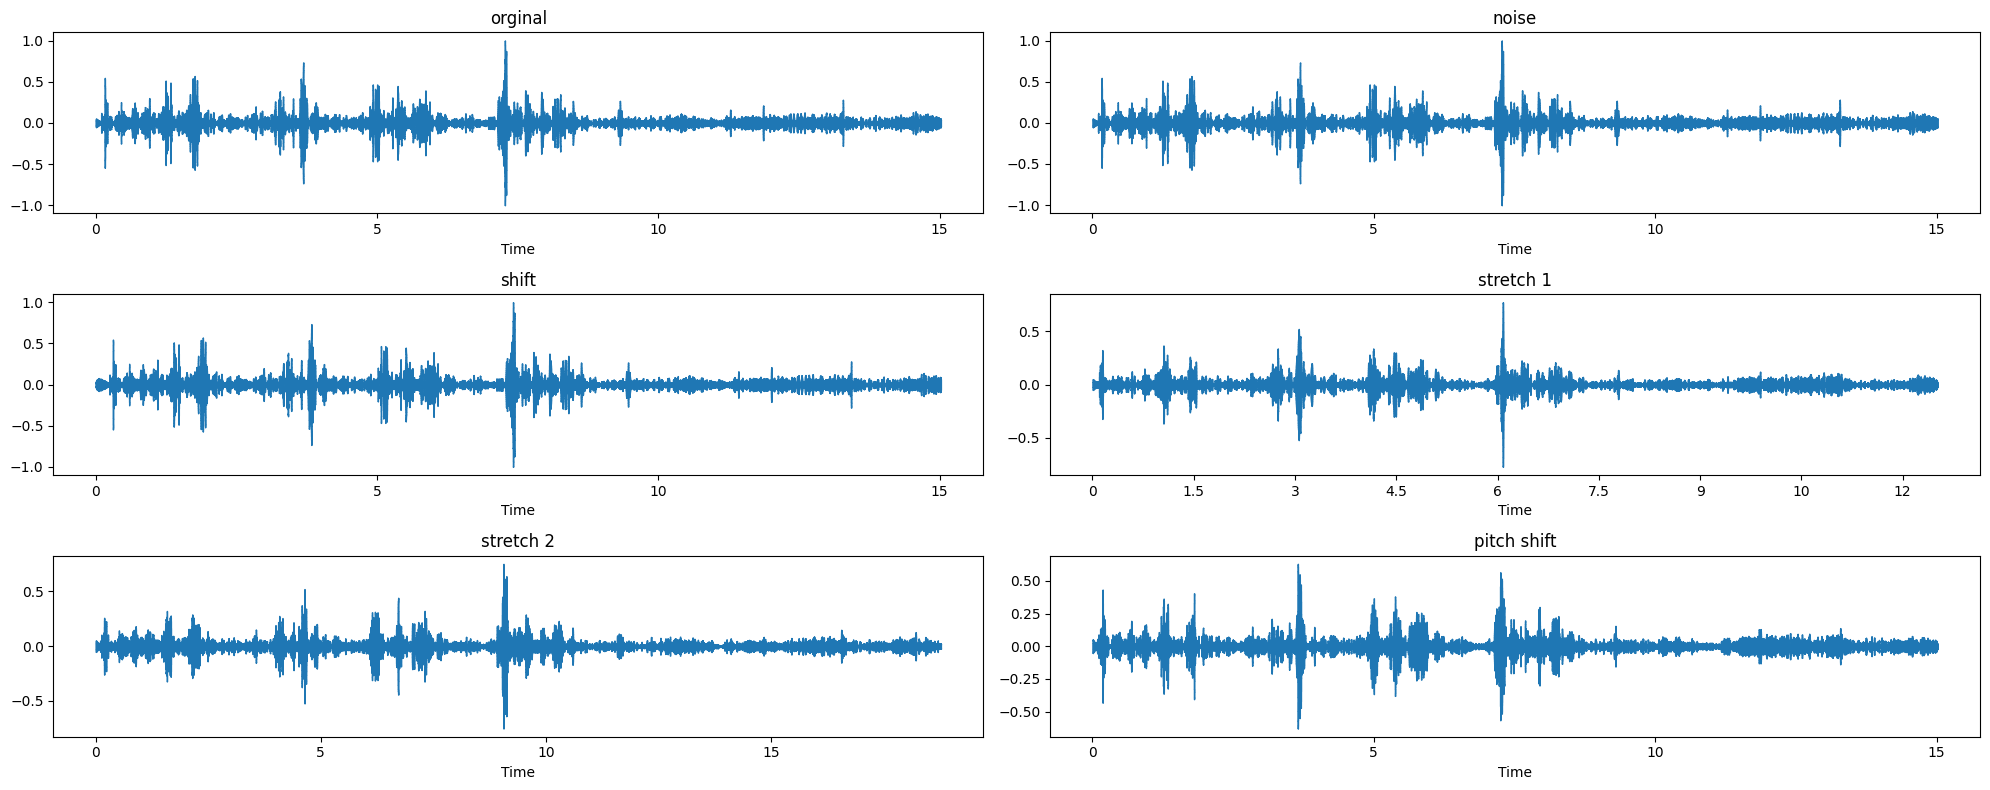

In [26]:
show_audio(audio1)

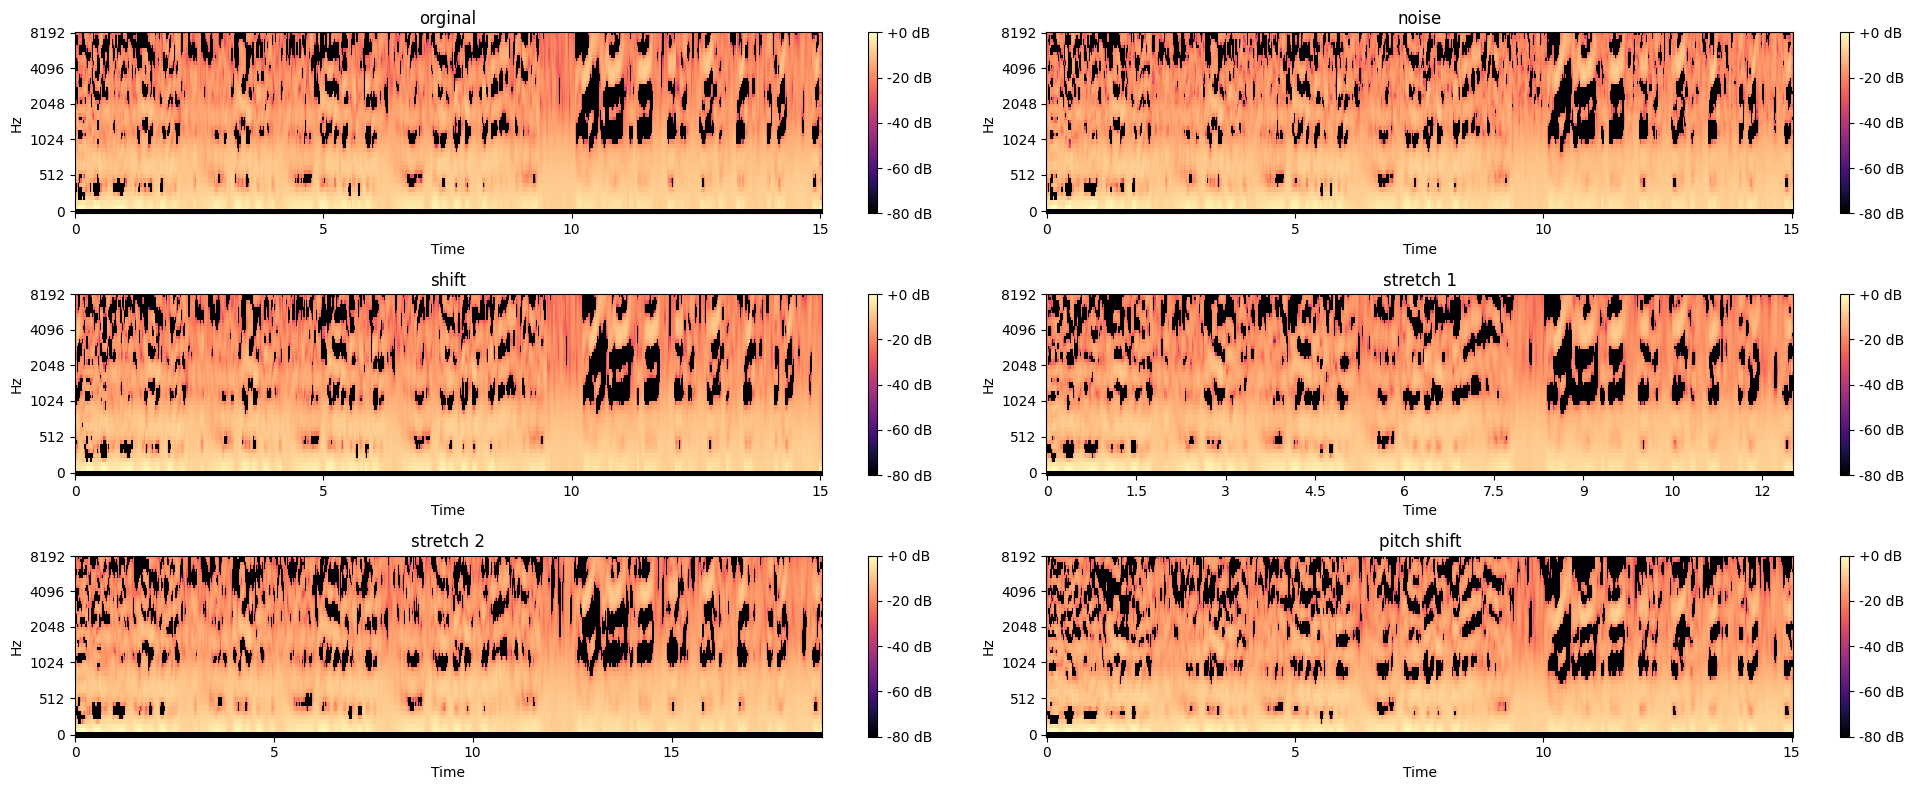

In [27]:
show_audio_features(audio1)

### Creating Augmented Data

In [28]:
# ⚠️ Make sure you use the Updated function.
# Function : mfccs_feature_exteraction
    # This is the Old function : 
    # mfccs_feature_exteraction(audio_data_folder)
x_mfccs, y = mfcc_feature_extraction(dir_=audio_data_folder,diagnosis_df=diagnosis_df)

Processing 920 audio files...
Processed 50/920 files...
Processed 100/920 files...
Processed 150/920 files...
Processed 200/920 files...
Processed 250/920 files...
Processed 300/920 files...
Processed 350/920 files...
Processed 400/920 files...
Processed 450/920 files...
Processed 500/920 files...
Processed 550/920 files...
Processed 600/920 files...
Processed 650/920 files...
Processed 700/920 files...
Processed 750/920 files...
Processed 800/920 files...
Processed 850/920 files...
Processed 900/920 files...

Feature extraction completed!
Final dataset shape: (997, 52)
Label distribution: {'Acute': 450, 'Chronic': 337, 'Healthy': 210}


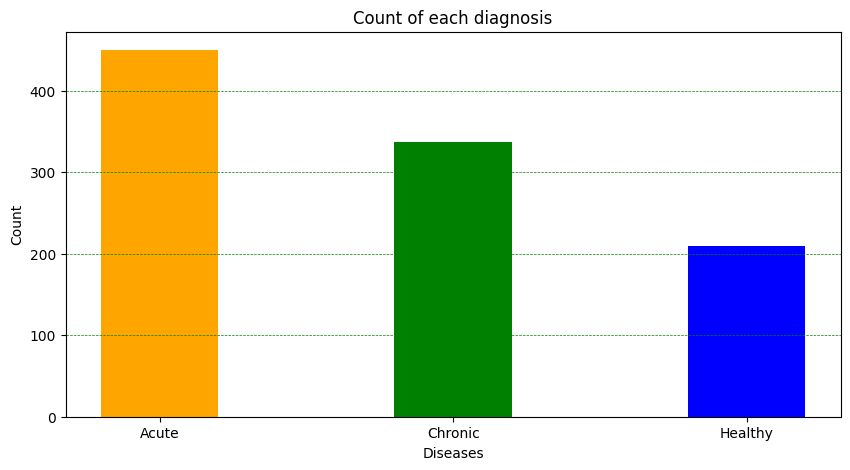

{'Acute': 450, 'Chronic': 337, 'Healthy': 210}


In [29]:
augmented_lables_count(y)
# {'Acute': 450, 'Chronic': 323, 'Healthy': 210}
# {'Acute': 450, 'Chronic': 323, 'Healthy': 222}
# {'Acute': 438, 'Chronic': 321, 'Healthy': 222}
# {'Acute': 372, 'Chronic': 321, 'Healthy': 222}
# {'Acute': 372, 'Chronic': 327, 'Healthy': 312}
# {'Acute': 372, 'Chronic': 329, 'Healthy': 312}
# {'Acute': 450, 'Chronic': 337, 'Healthy': 210}

### Encode string labels to one-hot categorical representation.

In [30]:
Y_data = encode_labels_to_categorical(y=y)

In [31]:
type(Y_data)

numpy.ndarray

In [32]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((997, 52), (997, 3))

In [33]:
lables

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Setting Up DeepRespNet

### Splitting Data for Training Testing and Validation

In [33]:
# mfcc_train, mfcc_val, lables_train, lables_val  = train_test_split(mfccs_features, lables, test_size=0.175, random_state=10)
# mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfcc_train, lables_train, test_size=0.075, random_state=10)

# print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
# print (lables_train.shape, lables_val.shape, lables_test.shape)

In [34]:
# Step 1: Split the data into training and remaining (validation + testing)
mfcc_train_val, mfcc_test, lables_train_val, lables_test = train_test_split(mfccs_features, lables, test_size=0.10, random_state=10)
# Step 2: Further split the remaining data into validation and testing
# Calculate the ratio of validation to total remaining data (90% of original)
validation_ratio = 0.20 / 0.90  # Ratio of validation data to remaining data
mfcc_train, mfcc_val, lables_train, lables_val = train_test_split(mfcc_train_val, lables_train_val, test_size=validation_ratio, random_state=10)

# Print the shapes of the resulting datasets
print("Training Data:")
print("MFCC Train Shape:", mfcc_train.shape)
print("Labels Train Shape:", lables_train.shape)

print("\nValidation Data:")
print("MFCC Validation Shape:", mfcc_val.shape)
print("Labels Validation Shape:", lables_val.shape)

print("\nTesting Data:")
print("MFCC Test Shape:", mfcc_test.shape)
print("Labels Test Shape:", lables_test.shape)

Training Data:
MFCC Train Shape: (697, 52)
Labels Train Shape: (697, 3)

Validation Data:
MFCC Validation Shape: (200, 52)
Labels Validation Shape: (200, 3)

Testing Data:
MFCC Test Shape: (100, 52)
Labels Test Shape: (100, 3)


In [35]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(lables_train,axis=1)
y_val_gru = np.expand_dims(lables_val,axis=1)
y_test_gru = np.expand_dims(lables_test,axis=1)

### Designing the DeepRespNet Model

In [36]:
deeprespnet_model = create_model()

In [37]:
deeprespnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 52)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1, 256)               66816     ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 1, 256)               0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 1, 256)               1024      ['max_pooling1d[0][0]']   

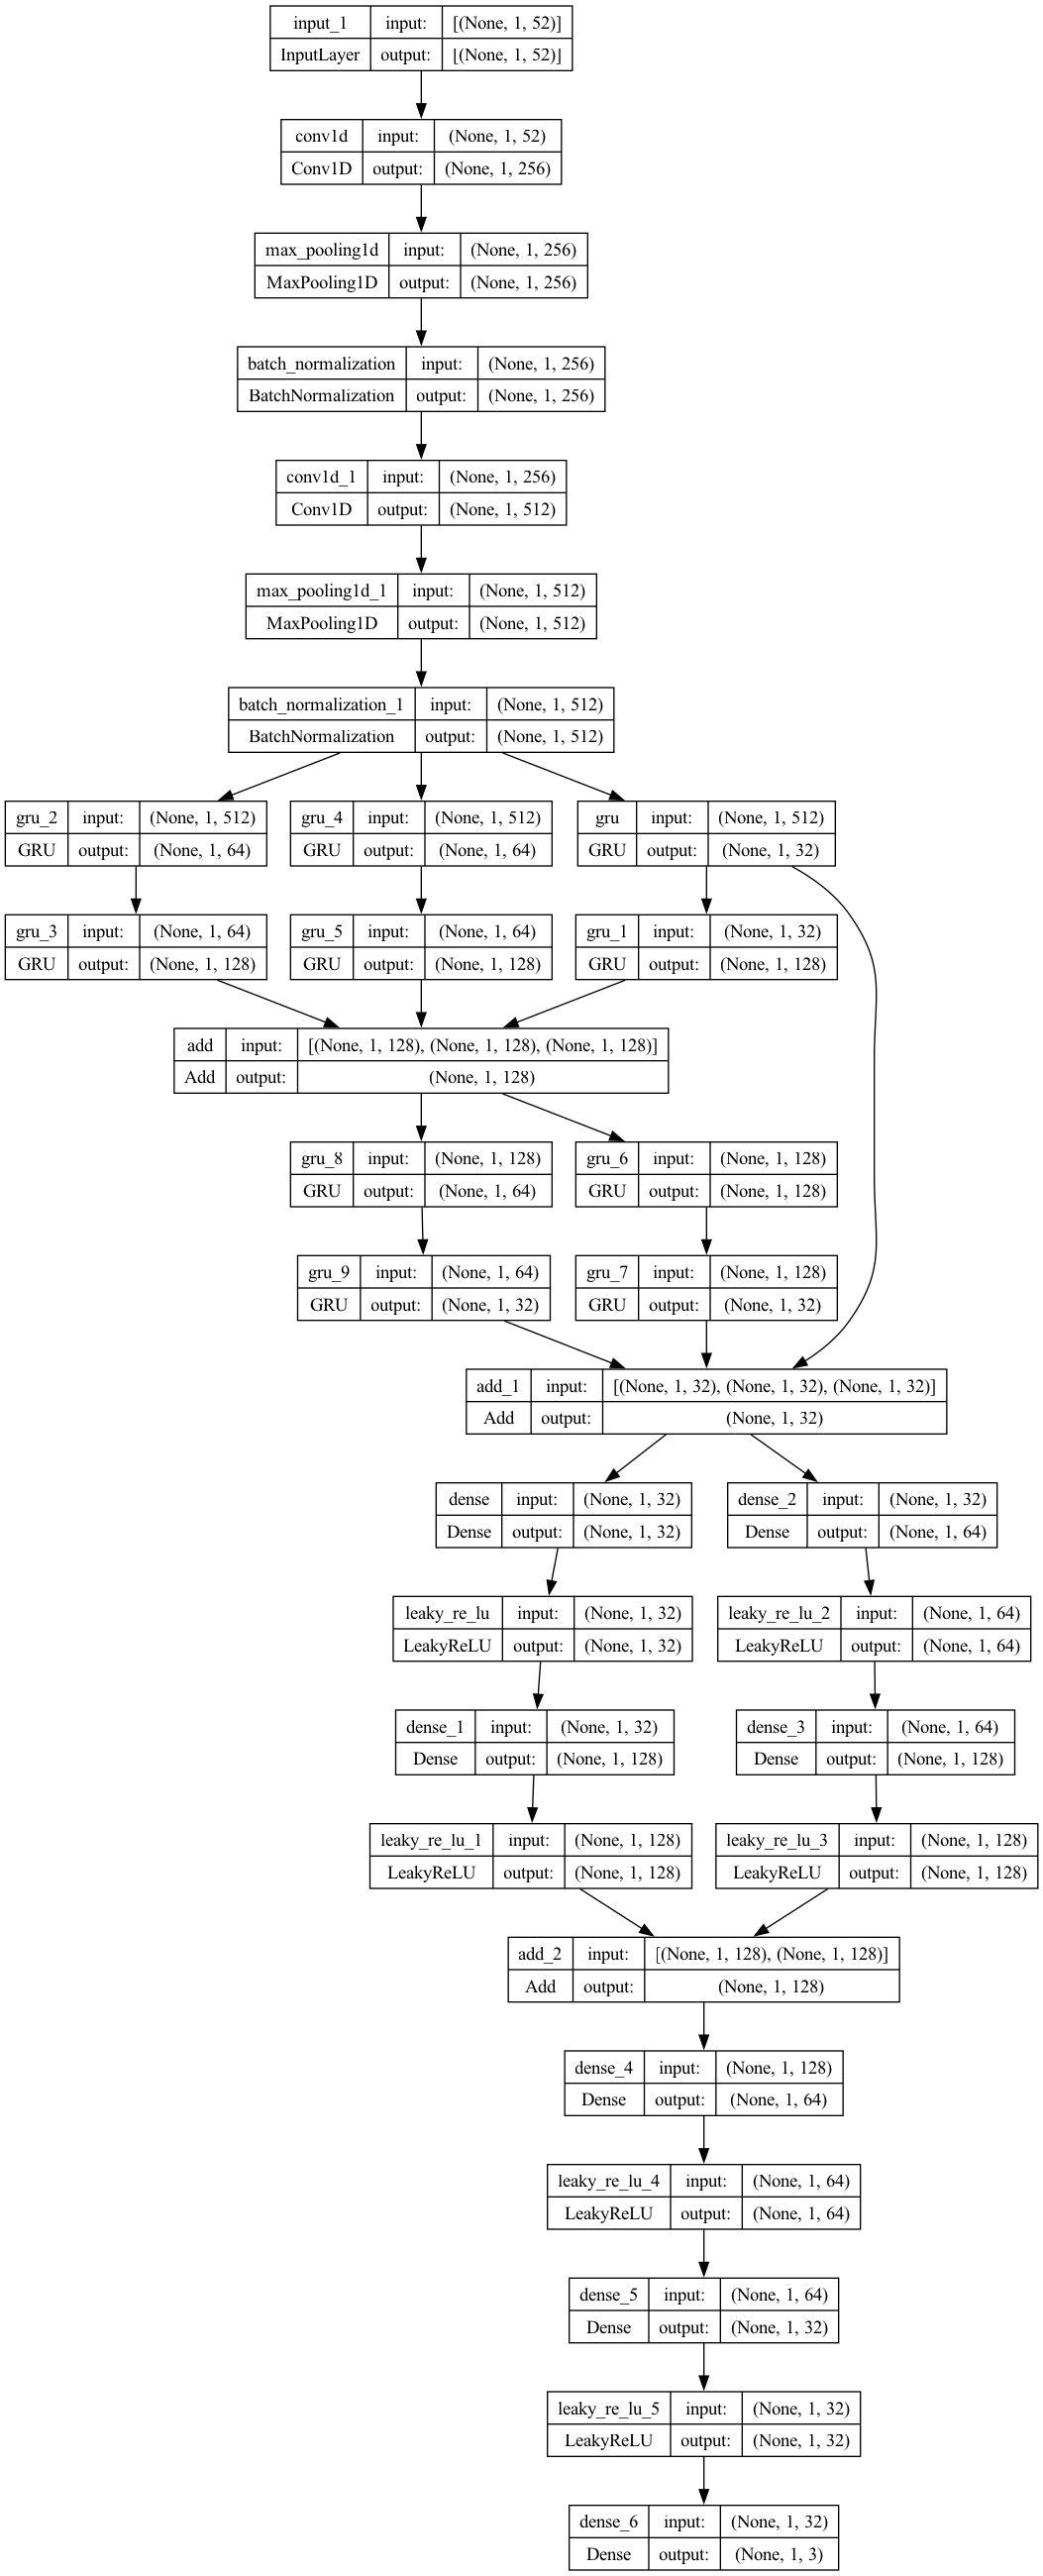

In [39]:
tf.keras.utils.plot_model(deeprespnet_model, "gru_model.png", show_shapes=True)

### Train DeepRespNet Model

In [38]:
history = train_model(deeprespnet_model,x_train_gru,y_train_gru,x_val_gru,y_val_gru)

Epoch 1/1000
22/22 [==============================] - 8s 81ms/step - loss: 0.9852 - accuracy: 0.5911 - val_loss: 1.0548 - val_accuracy: 0.4400
Epoch 2/1000
 8/22 [=========>....................] - ETA: 0s - loss: 0.8466 - accuracy: 0.6602

/Users/khubaib/Downloads/DeepRespNet/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 0s 20ms/step - loss: 0.8114 - accuracy: 0.6671 - val_loss: 1.0396 - val_accuracy: 0.4550
Epoch 3/1000
22/22 [==============================] - 0s 18ms/step - loss: 0.6694 - accuracy: 0.7432 - val_loss: 0.9949 - val_accuracy: 0.5150
Epoch 4/1000
22/22 [==============================] - 0s 18ms/step - loss: 0.5703 - accuracy: 0.7805 - val_loss: 0.9055 - val_accuracy: 0.5800
Epoch 5/1000
22/22 [==============================] - 0s 19ms/step - loss: 0.4928 - accuracy: 0.8006 - val_loss: 0.8938 - val_accuracy: 0.6450
Epoch 6/1000
22/22 [==============================] - 0s 18ms/step - loss: 0.4335 - accuracy: 0.8379 - val_loss: 0.7736 - val_accuracy: 0.6350
Epoch 7/1000
22/22 [==============================] - 0s 19ms/step - loss: 0.4139 - accuracy: 0.8522 - val_loss: 0.7138 - val_accuracy: 0.6950
Epoch 8/1000
22/22 [==============================] - 0s 19ms/step - loss: 0.3501 - accuracy: 0.8737 - val_loss: 0.6729 - val_accuracy: 0.7150
Epoch 9/1000

### Evaluating The Model Accuracy

In [ ]:
deeprespnet_model.evaluate(x_train_gru, y_train_gru)
#model 2:  24/24 [==============================] - 0s 4ms/step - loss: 0.0719 - accuracy: 0.9666
#model 3:  24/24 [==============================] - 0s 3ms/step - loss: 0.0447 - accuracy: 0.9775
#model 4:  23/23 [==============================] - 0s 3ms/step - loss: 0.0584 - accuracy: 0.9661
#model 5:  23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9754 - loss: 0.0529

#model 6: 22/22 [==============================] - 0s 5ms/step - loss: 0.3343 - accuracy: 0.8646
#model 6: 22/22 [==============================] - 0s 3ms/step - loss: 0.5264 - accuracy: 0.7700
#model 7: 22/22 [==============================] - 0s 3ms/step - loss: 0.0057 - accuracy: 1.0000

22/22 [==============================] - 0s 3ms/step - loss: 0.0057 - accuracy: 1.0000


[0.005716612096875906, 1.0]

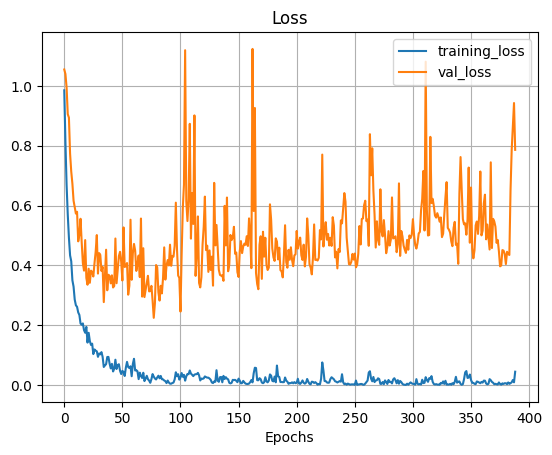

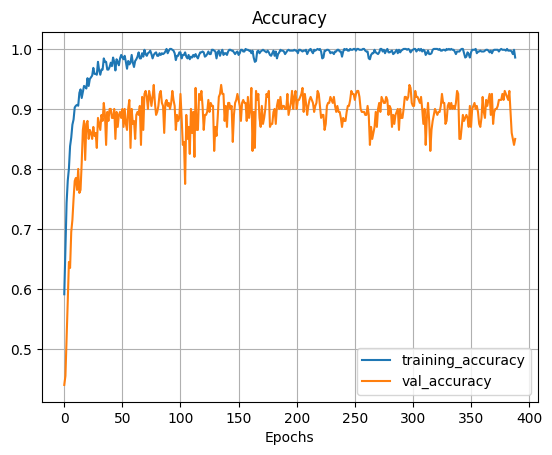

In [41]:
plot_loss_curves(history)

4/4 [==============================] - 1s 3ms/step


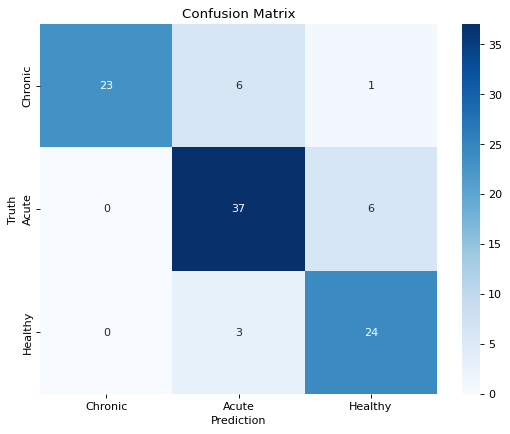

In [42]:
classes = ['Chronic','Acute','Healthy']

preds = deeprespnet_model.predict(x_test_gru)
classpreds = [np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [43]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

     Chronic       1.00      0.77      0.87        30
       Acute       0.80      0.86      0.83        43
     Healthy       0.77      0.89      0.83        27

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



### Saving The DeepRespNet Model

In [ ]:
# # Save the model in the native Keras format
# # I don't know what to use
# deeprespnet_model.save('diagnosis_GRU_CNN_6.keras')
deeprespnet_model.save("./diagnosis_model8.h5")

/Users/khubaib/Downloads/DeepRespNet/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Manual Test

In [45]:
gru_diagnosis_prediction(test_audio=audio2,model=deeprespnet_model,classes=classes)

1/1 [==============================] - 0s 30ms/step
Predicted Diagnosis: Healthy
Confidence Score: 0.9997 (99.97%)


('Healthy', 0.99969065)

In [46]:
gru_diagnosis_prediction(audio3,model=deeprespnet_model,classes=classes)

1/1 [==============================] - 0s 17ms/step
Predicted Diagnosis: Acute
Confidence Score: 0.9991 (99.91%)


('Acute', 0.99906844)

In [47]:
gru_diagnosis_prediction(audio5,model=deeprespnet_model,classes=classes)

1/1 [==============================] - 0s 18ms/step
Predicted Diagnosis: Acute
Confidence Score: 0.9807 (98.07%)


('Acute', 0.98067254)

In [48]:
gru_diagnosis_prediction(audio6,model=deeprespnet_model,classes=classes)

1/1 [==============================] - 0s 27ms/step
Predicted Diagnosis: Acute
Confidence Score: 0.9526 (95.26%)


('Acute', 0.952641)

## Extra

In [49]:
deeprespnet_model.history

In [50]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


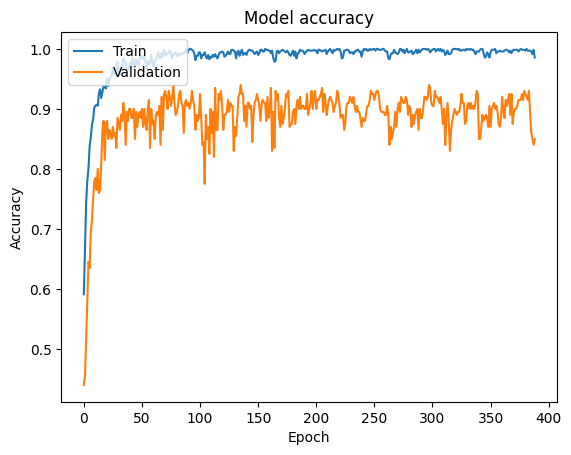

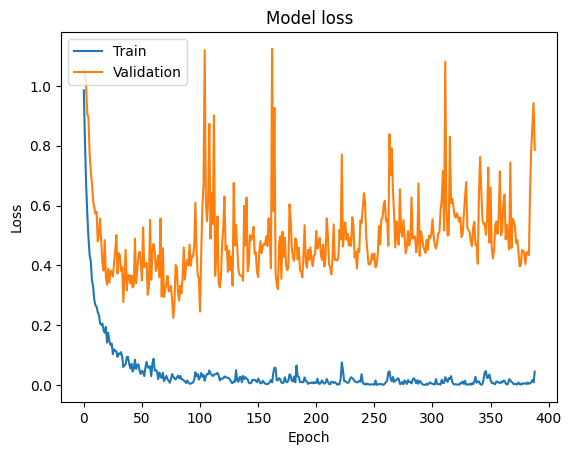

In [51]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# import pickle
# with open('model5_training_history.pkl', 'wb') as file:
#     pickle.dump(history.history, file)

In [ ]:
# import pickle
# import matplotlib.pyplot as plt

# # Load the saved history data from the file
# with open('model5_training_history.pkl', 'rb') as file:
#     loaded_history = pickle.load(file)

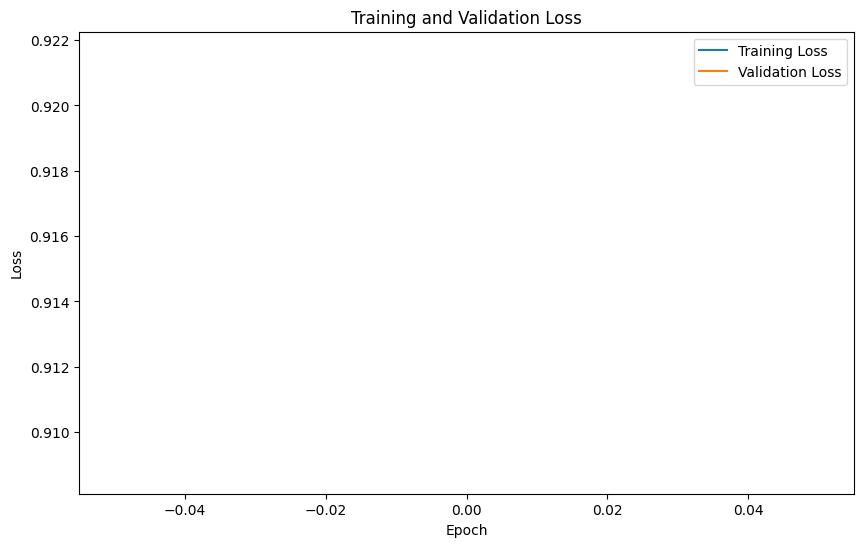

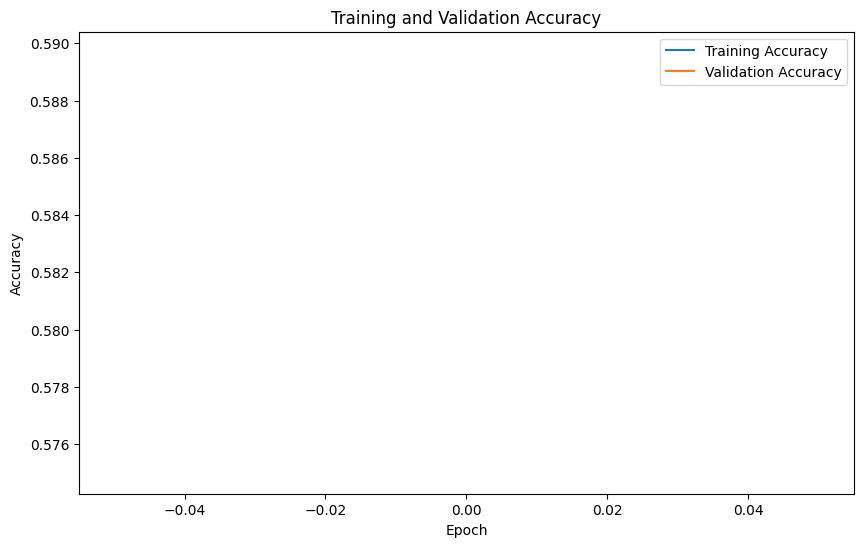

In [ ]:
# #  Plot training and validation loss
# plt.figure(figsize=(10, 6))
# plt.plot(loaded_history['loss'], label='Training Loss')
# plt.plot(loaded_history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot training and validation accuracy
# plt.figure(figsize=(10, 6))
# plt.plot(loaded_history['accuracy'], label='Training Accuracy')
# plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# df = pd.DataFrame()

In [ ]:
# df['accuracy']=history.history['accuracy']

In [ ]:
# df['accuracy']

0    0.58967
Name: accuracy, dtype: float64

In [ ]:
# df['val_accuracy'] = history.history['val_accuracy']

In [ ]:
# df

,accuracy,val_accuracy
0,0.58967,0.575


In [ ]:
# df.to_csv('./model6_accuracy_epoch_values.csv',index=None) # type: ignore